In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pickle

# **LSTM Model**

In [ ]:
class LSTM_Model:
  data=None
  timestep=None
  LSTM_Neurons=None
  scaler=None
  trained_model=None

  def __init__(self,LSTM_Neurons,timestep) -> None:
     self.LSTM_Neurons=LSTM_Neurons
     self.timestep=timestep
  
  #Loading the data from excel
  def load_data(self,path,sheet_name,field):
    self.data = pd.read_excel(path,sheet_name=sheet_name)
    self.data=np.array(self.data['AQI'].tolist())

  def get_scaler(self):
    return self.scaler
    
  #Preprocessing and scaling the data
  def preprocess_data(self):
    self.scaler = MinMaxScaler()
    self.scaler = self.scaler.fit(self.data.reshape(-1, 1))
    scaled_data = self.scaler.transform(self.data.reshape(-1, 1))
    return scaled_data

  def create_data_and_labels(self):
    scaled_data=self.preprocess_data()
    X = []
    y = []
    for i in range(self.timestep, len(self.data)):
        X.append(scaled_data[i-self.timestep:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    return X,y

  def create_training_and_testing_data(self,X,y):
    # Split the data into training and testing sets
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    return X_train,y_train,X_test,y_test
    
  # Define the LSTM model architecture
  def create_LSTM_Model(self):
    model = Sequential()
    model.add(LSTM(self.LSTM_Neurons, input_shape=(self.timestep, 1),activation="tanh"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

  def fit_data(self,model,X_train,y_train):
    model.fit(X_train, y_train, epochs=100, batch_size=32,verbose=False)
    return model

  def predict(self,model,X_test,y_test):
    y_pred = model.predict(X_test,verbose=False)
    y_pred = self.scaler.inverse_transform(y_pred)
    y_test = self.scaler.inverse_transform(y_test.reshape(1,-1))
    print('Predicted')
    print([i[0] for i in y_pred])
    print("Actual")
    print(y_test[0])
    return y_pred,y_test

  def evaluate_rmse(self,model,y_pred,y_test):
    mse = np.mean((y_pred - y_test)**2)
    print("Mean squared error:", mse)

  def plot_test_and_predicted(self,y_pred,y_test):
    fig=plt.figure(figsize=(7,7))
    plt.plot([i[0] for i in y_pred],label='Predicted',color='orange')
    plt.plot(y_test[0],label="Actual",color='blue')
    plt.legend()
    plt.show()
  
  def get_model(self):
    return self.trained_model

  def forecast_future(self,forecast_horizon):
    last_values = self.data[-self.timestep:]
    input_sequence = self.scaler.transform(last_values.reshape(-1, 1)).reshape(1, self.timestep)

    # Generate `num_predictions` future values using the model
    output=[]
    for i in range(forecast_horizon):
        # Predict the next value based on the previous `timesteps` values
        next_value = self.trained_model.predict(input_sequence)[0, 0]
        
        # Add the predicted value to the input sequence and remove the first value
        input_sequence = np.concatenate([input_sequence[:, 1:], [[next_value]]], axis=1)
        
        # Scale the input sequence for the next prediction
        input_sequence_scaled = self.scaler.inverse_transform(input_sequence.reshape(-1, 1)).reshape(1, self.timestep, 1)
        
        # Print the predicted value
        output.append(next_value)
    return self.scaler.inverse_transform(np.array(output).reshape(-1,1))
    
  def execute(self):
    X,y=self.create_data_and_labels()
    X_train,y_train,X_test,y_test=self.create_training_and_testing_data(X,y)
    model=self.create_LSTM_Model()
    fitted_model=self.fit_data(model,X_train,y_train)
    y_pred,y_test=self.predict(fitted_model,X_test,y_test)
    self.plot_test_and_predicted(y_pred,y_test)
    self.evaluate_rmse(fitted_model,y_pred,y_test)
    model=self.create_LSTM_Model()
    fitted_model=self.fit_data(model,X,y)
    self.trained_model=fitted_model
    return y_pred,y_test

Predicted
[66.71613, 66.15122, 65.5885, 65.02803, 64.46986, 63.91401, 63.36054, 62.809486, 62.260883, 66.819084, 64.342384, 63.260166, 58.34866, 62.260883, 62.260883, 66.819084, 63.260166]
Actual
[63.7        62.6        61.5        60.4        59.3        58.2
 57.1        56.         65.         60.14814815 58.         48.
 56.         56.         65.         58.         62.        ]


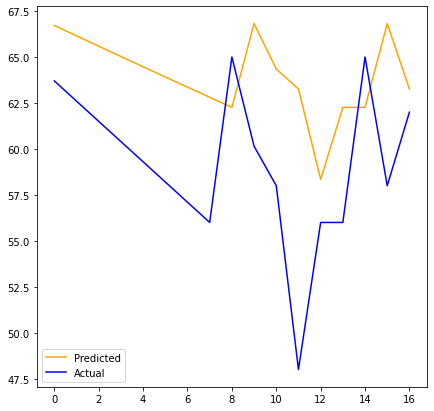

Mean squared error: 43.41453639174604
1/1 [==============================] - 0s 42ms/step
[[64.4501  ]
 [65.68063 ]
 [66.302124]
 [66.61687 ]
 [66.77648 ]
 [66.857475]
 [66.8986  ]
 [66.91947 ]
 [66.93008 ]
 [66.93546 ]
 [66.938194]
 [66.93958 ]
 [66.94029 ]
 [66.94065 ]
 [66.94083 ]]
Predicted
[57.804577, 54.532124, 53.816463, 59.65605, 62.28294, 58.816723, 58.542496, 59.65605, 61.52856, 59.284004, 58.624714, 57.804577, 54.8916, 57.437008, 57.804577, 61.152485, 58.542496]
Actual
[45.         43.         59.         66.         56.74074074 56.
 59.         64.         58.         56.22222222 54.         46.
 53.         54.         63.         56.         59.        ]


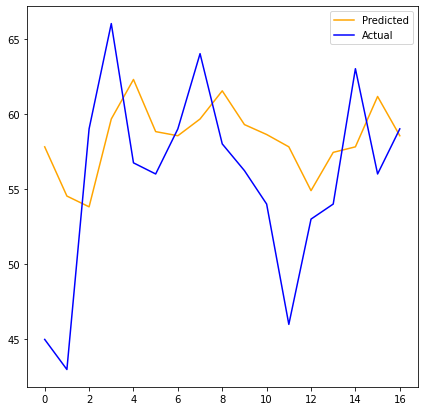

Mean squared error: 50.14846187808328
1/1 [==============================] - 0s 30ms/step
[[59.7562  ]
 [60.037525]
 [60.142357]
 [60.18145 ]
 [60.196026]
 [60.201466]
 [60.20349 ]
 [60.204247]
 [60.20453 ]
 [60.20463 ]
 [60.204674]
 [60.204685]
 [60.20469 ]
 [60.204693]
 [60.204693]]
Predicted
[73.031845, 61.941025, 66.75537, 65.222046, 67.78966, 68.04844, 69.86992, 71.31679, 68.35001, 68.63305, 69.81742, 76.780106, 58.898117, 61.69139, 59.217396, 69.08716, 73.031845]
Actual
[ 50.          59.49456459  56.5         61.5         62.
  65.5         68.25702631  62.58178632  63.12698041  65.39959018
  78.5         43.84860419  49.5         44.5         64.
  71.5        105.        ]


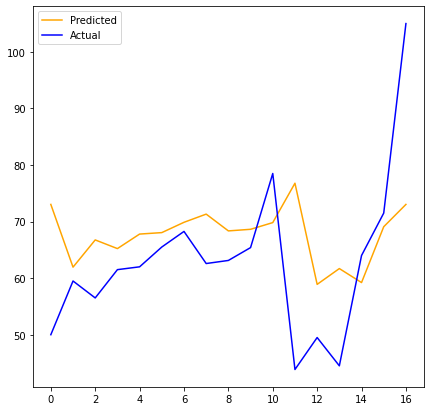

Mean squared error: 234.4897420033143
1/1 [==============================] - 0s 45ms/step
[[88.95868 ]
 [80.79581 ]
 [76.75969 ]
 [74.79694 ]
 [73.85075 ]
 [73.396614]
 [73.17911 ]
 [73.075035]
 [73.025276]
 [73.00148 ]
 [72.990105]
 [72.98466 ]
 [72.982056]
 [72.98082 ]
 [72.98023 ]]
Predicted
[71.84626, 75.275024, 76.02496, 77.24939, 79.73219, 84.24103, 76.01415, 77.376625, 74.57761, 74.84555, 75.96462, 82.481674, 65.50003, 68.211365, 65.8113, 75.275024, 78.98565]
Actual
[ 64.          65.52192329  68.          73.          82.
  65.5         68.25702631  62.58178632  63.12698041  65.39959018
  78.5         43.84860419  49.5         44.5         64.
  71.5        105.        ]


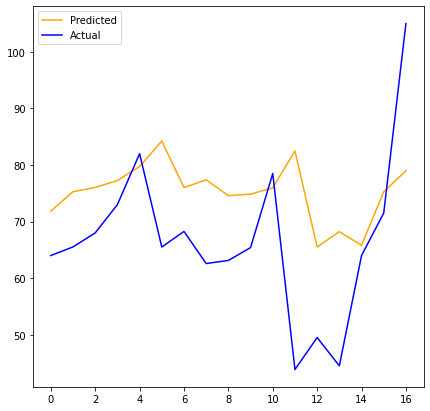

Mean squared error: 289.9892693296712
1/1 [==============================] - 0s 29ms/step
[[93.53368 ]
 [87.90449 ]
 [85.18968 ]
 [83.89224 ]
 [83.27493 ]
 [82.981834]
 [82.842834]
 [82.77695 ]
 [82.745705]
 [82.7309  ]
 [82.723885]
 [82.72056 ]
 [82.71899 ]
 [82.71824 ]
 [82.717896]]
Predicted
[77.341866, 76.74368, 77.8363, 76.77912, 78.46624, 75.21225, 69.79513, 64.02886, 69.42806, 77.31143]
Actual
[ 76.51851852  79.36573096  76.61111111  81.          72.5
  58.          42.          57.          78.         115.        ]


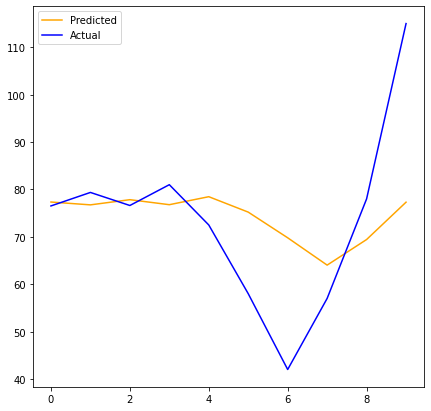

Mean squared error: 357.30851823889844
1/1 [==============================] - 0s 26ms/step
[[93.26138 ]
 [83.6223  ]
 [79.43271 ]
 [77.63037 ]
 [76.85868 ]
 [76.52898 ]
 [76.38822 ]
 [76.32818 ]
 [76.30255 ]
 [76.291626]
 [76.286964]
 [76.28497 ]
 [76.284134]
 [76.28377 ]
 [76.283615]]


In [ ]:
cities=['Adilabad','Nizamabad','Warangal','Karimnagar','Khammam']
for city in cities:
  model=LSTM_Model(50, 1)
  model.load_data('/content/drive/MyDrive/NASSCOMM Hackathon/AQI Dataset/AAQ-AQI-interpolated.xlsx',city,'AQI')
  y_pred,y_test=model.execute()
  forecasted_values = model.forecast_future(15)
  print(forecasted_values)
  city_df=pd.DataFrame()
  city_df['Actual']=y_test
  city_df['Predicted']=y_pred
  city_df['']

In [ ]:
picklefile=open('adilabad_AQI_LSTM.pickle','wb')
pickle.dump(adilabad_model,picklefile)
picklefile.close()

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
variables.h5                                   2023-02-19 07:07:20       145576
config.json                                    2023-02-19 07:07:19         1808
metadata.json                                  2023-02-19 07:07:19           64


In [ ]:
picklefile = open('/content/adilabad_AQI_LSTM.pickle', 'rb')
#unpickle the dataframe
pickle_model = pickle.load(picklefile)
#close file
picklefile.close()

pickle_model.forecast_future(15)

Keras model archive loading:
File Name                                             Modified             Size
variables.h5                                   2023-02-19 07:07:20       145576
config.json                                    2023-02-19 07:07:18         1808
metadata.json                                  2023-02-19 07:07:18           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
1/1 [==============================] - 0s 34ms/step


array([[94.925064],
       [85.450226],
       [81.04393 ],
       [79.0114  ],
       [78.07763 ],
       [77.64947 ],
       [77.453316],
       [77.36349 ],
       [77.32236 ],
       [77.30353 ],
       [77.294914],
       [77.29098 ],
       [77.28917 ],
       [77.28834 ],
       [77.28796 ]], dtype=float32)

In [ ]:
picklefile=open('adilabad_scaler.pickle','wb')
pickle.dump(adilabad_model.get_scaler(),picklefile)
picklefile.close()

In [ ]:
model=adilabad_model.get_model().save('adilabad.h5')